In [1]:
# SETUP, IMPORTS, AND CONFIGURATION

# !pip install yfinance fredapi pandas textblob matplotlib fpdf seaborn

# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from textblob import TextBlob
from fpdf import FPDF
from IPython.display import display 
import os, datetime, hashlib, json, warnings, string
import time # For interactive delay

warnings.filterwarnings("ignore")

# --- Configuration and Directory Setup ---

FRED_API_KEY = os.environ.get("FRED_API_KEY", "e9b13c9f61d9447309d4c104b82a45d1")
fred = Fred(api_key=FRED_API_KEY)
CONFIG = {"memory_dir":"memory", "report_dir":"reports"}

# Create necessary directories
os.makedirs(CONFIG["memory_dir"], exist_ok=True)
os.makedirs(CONFIG["report_dir"], exist_ok=True)

print("Setup complete. Configuration directories created/verified.")
print("FRED API initialized.")

Setup complete. Configuration directories created/verified.
FRED API initialized.


In [2]:
# DATA HANDLING, FETCHING, AND CORE ANALYSIS FUNCTIONS

# --- Memory Functions ---
def load_memory(ticker):
    """Loads a ticker's persistent notes/summary from a file."""
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    return json.load(open(path)) if os.path.exists(path) else {"notes":"No prior analysis","last_run":None}

def save_memory(ticker, data):
    """Saves a ticker's notes/summary for future runs."""
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    json.dump(data, open(path,"w"), indent=2)

# --- Data Fetching Tools ---
def fetch_yfinance_data(ticker):
    """Tool: Fetches historical prices (1y) and news using yfinance."""
    print(f"    [Tool Use] Fetching yfinance data for {ticker}...")
    try:
        t = yf.Ticker(ticker)
        hist = t.history(period="1y").reset_index() 
        news = t.news or []
        return hist, news
    except Exception as e:
        print(f"        [Error] Failed to fetch yfinance data for {ticker}: {e}")
        return pd.DataFrame(), []

def fetch_fred_data(series_id):
    """Tool: Fetches economic data using FRED API (e.g., CPIAUCSL)."""
    try:
        s = fred.get_series(series_id)
        if s is None or s.empty:
            return pd.DataFrame()
            
        df = pd.DataFrame(s).reset_index()
        data_col_name = df.columns[-1]
        df.rename(columns={data_col_name: series_id, 'index': 'date'}, inplace=True)
        return df
    except Exception as e:
        print(f"        Error fetching FRED data: {e}")
        return pd.DataFrame()

# --- Core Analysis Functions ---
def compute_rsi(series, window=14):
    """Tool: Computes Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = (delta.where(delta>0,0)).rolling(window).mean()
    loss = (-delta.where(delta<0,0)).rolling(window).mean()
    rsi = 100 - (100 / (1 + gain/loss))
    return rsi

def news_impact_analyzer(news_list, ticker):
    """
    Workflow: Sentiment analysis with simulated NER/POS filtering.
    Applies a weight (1.0 for high impact, 0.5 for low impact) to sentiment.
    """
    results=[]
    high_impact_keywords = ["acquire", "launch", "missed", "soared", "failed", "record", "major"]
    
    for n in news_list:
        t = n.get("title","").lower()
        if t:
            s = TextBlob(t).sentiment.polarity
            is_high_impact = any(k in t for k in high_impact_keywords) and ticker.lower() in t.lower()
            sentiment_weight = 1.0 if is_high_impact else 0.5
            weighted_s = s * sentiment_weight
            
            tone = "positive" if weighted_s > 0.1 else "negative" if weighted_s < -0.1 else "neutral"
            results.append({"title":n.get("title",""),"sentiment":round(s,2),"weighted_sentiment":round(weighted_s,2),"tone":tone})
            
    df=pd.DataFrame(results)
    overall_sentiment = df['weighted_sentiment'].mean() if not df.empty else 0
    return df, overall_sentiment

In [3]:
# VISUALIZATION FUNCTIONS 


def plot_price_and_rsi(df, ticker, rsi):
    """Tool: Plots stock price and RSI and saves the image."""
    if df.empty or rsi.empty: return None

    # Use a style for better presentation
    plt.style.use('seaborn-v0_8-whitegrid') 

    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6),sharex=True)
    
    # --- Price Plot ---
    ax1.plot(df["Date"],df["Close"],label="Close", color='darkblue', linewidth=1.5)
    ax1.plot(df["Date"],df["Close"].rolling(50).mean(),label="MA-50", color='orange', linestyle='--')
    ax1.plot(df["Date"],df["Close"].rolling(200).mean(),label="MA-200", color='red', linestyle='--')
    ax1.set_title(f"{ticker} Price and Moving Averages", fontsize=14)
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='y', labelcolor='darkblue')

    # --- RSI Plot ---
    ax2.plot(df["Date"],rsi,label="RSI-14",color="purple", linewidth=1.5)
    ax2.axhline(70,color='red',linestyle="--",alpha=0.7,label="Overbought")
    ax2.axhline(30,color='green',linestyle="--",alpha=0.7,label="Oversold")
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.set_title("RSI Trends", fontsize=14)
    ax2.set_xlabel("Date")

    path=f"{CONFIG['report_dir']}/{ticker}_price_rsi.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    
    print(f"        [Chart] Generated Price & RSI chart: {os.path.basename(path)}")
    return path

def plot_macro_correlation(stock_df, macro_df, ticker, macro_key):
    """Tool: Plots price vs macro indicator, returns correlation, and saves the image."""
    stock_df_fixed = stock_df.copy()
    if pd.api.types.is_datetime64_any_dtype(stock_df_fixed["Date"]) and stock_df_fixed["Date"].dt.tz is not None:
        stock_df_fixed["Date"]=stock_df_fixed["Date"].dt.tz_localize(None)
    
    merged=pd.merge(stock_df_fixed,macro_df,left_on="Date",right_on="date",how="inner")
    
    if merged.empty or len(merged) < 5: return None, None
    
    corr=merged[["Close",macro_key]].corr().iloc[0,1]
    
    plt.style.use('seaborn-v0_8-whitegrid') 
    fig,ax1=plt.subplots(figsize=(10,5))
    
    # --- Price Plot (Left Axis) ---
    ax1.plot(merged["Date"],merged["Close"],label=f"{ticker} Close",color="blue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"{ticker} Close Price", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    # --- Macro Plot (Right Axis) ---
    ax2=ax1.twinx()
    ax2.plot(merged["date"],merged[macro_key],label=macro_key.upper(),color="orange",linestyle="--")
    ax2.set_ylabel(macro_key.upper(), color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")
    
    plt.title(f"{ticker} vs {macro_key.upper()} (Correlation: {corr:.2f})", fontsize=14)
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    path=f"{CONFIG['report_dir']}/{ticker}_{macro_key}_corr.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    
    print(f"        [Chart] Generated Macro Correlation chart: {os.path.basename(path)}")
    return path, corr

def plot_sentiment_distribution(df, ticker):
    """Tool: Plots news sentiment distribution and saves the image."""
    if df.empty: return None
    
    plt.style.use('seaborn-v0_8-whitegrid') 
    plt.figure(figsize=(5,4))
    
    # Use different colors for better contrast
    colors = ['green' if x == 'positive' else 'red' if x == 'negative' else 'gray' for x in df["tone"].value_counts().index]
    df["tone"].value_counts().plot(kind="bar", color=colors, alpha=0.7)
    
    plt.title(f"News Sentiment Distribution ({ticker})", fontsize=14)
    plt.xticks(rotation=0, ha='center')
    plt.ylabel("Number of Articles")
    plt.xlabel("Sentiment Tone")
    
    path=f"{CONFIG['report_dir']}/{ticker}_sentiment.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    
    print(f"        [Chart] Generated Sentiment chart: {os.path.basename(path)}")
    return path

In [4]:
# SPECIALIST AGENT CLASSES

class PriceAnalyzer:
    """Specialist: Analyzes price data, calculating RSI and trend regime."""
    def analyze(self,hist):
        if hist.empty or "Close" not in hist.columns or len(hist) < 20: 
            print("        [Warning] PriceAnalyzer received insufficient historical data.")
            return {"rsi": None, "regime": "N/A (Data Unavailable)"}

        rsi=compute_rsi(hist["Close"])
        
        if rsi.empty or rsi.iloc[-1].item() is np.nan:
            rsi_value = None
            regime = "N/A (Insufficient Data)"
        else:
            rsi_value = rsi.iloc[-1].item()
            # Calculate 20-day Moving Average for trend regime
            ma_20 = hist["Close"].rolling(20).mean().iloc[-1]
            regime="Uptrend" if hist["Close"].iloc[-1] > ma_20 else "Downtrend"
            
        return {"rsi": rsi_value, "regime": regime}

class MacroAnalyzer:
    """Specialist: Analyzes macro-economic data and correlation (default: CPI)."""
    def analyze(self,hist,ticker,macro_key="CPIAUCSL"):
        macro=fetch_fred_data(macro_key)
        # plot_macro_correlation now only returns correlation and None for path
        path,corr=plot_macro_correlation(hist,macro,ticker,macro_key)
        return {"corr":corr, "plot_path": path}

class NewsAnalyzer:
    """Specialist: Analyzes news sentiment using the weighted scoring logic."""
    def analyze(self,news, ticker):
        df,sentiment=news_impact_analyzer(news, ticker)
        return {"sentiment":sentiment,"news_df":df,"num_news":len(df)}

In [5]:
# INVESTMENT RESEARCH AGENT (ORCHESTRATOR)


class InvestmentResearchAgent:
    def __init__(self):
        self.specialists={"price":PriceAnalyzer(),"macro":MacroAnalyzer(),"news":NewsAnalyzer()}

    def evaluate_quality(self,report):
        """Generates quality metrics (clarity, accuracy, evidence, confidence)."""
        clarity = 1.0 if report["macro"]["corr"] is not None else 0.5
        accuracy = 1.0 - abs(report["news"]["sentiment"]-0.5)
        evidence = 1.0 if report["news"]["num_news"]>0 else 0.2
        confidence = (clarity+accuracy+evidence)/3
        return {"clarity":clarity,"accuracy":accuracy,"evidence":evidence,"confidence":confidence}

    def run(self,ticker, prompt_type="summary"):
        """Executes the full agentic research process for a given ticker."""
        if ticker is None: return None
        
        print(f"\n🧠 Agent Starting Run for {ticker} ({prompt_type})")
        
        # 1. Fetch Data
        hist,news=fetch_yfinance_data(ticker)
        memory=load_memory(ticker)
        print(f"    [Agent Learns] Prior Notes ({memory['last_run'] or 'N/A'}): {memory['notes']}")
        
        # 2. Routing to Specialists
        price_out=self.specialists["price"].analyze(hist)
        macro_out=self.specialists["macro"].analyze(hist,ticker)
        news_out=self.specialists["news"].analyze(news, ticker) 
        
        # 3. Compiling Raw Report Data
        report={"ticker":ticker,"price":price_out,"macro":macro_out,"news":news_out}
        
        # 4. Visualization (Plots are NOT generated, paths are None)
        plots=[]
        plots.append(plot_price_and_rsi(hist, ticker, compute_rsi(hist["Close"])))
        if macro_out.get("plot_path"): plots.append(macro_out["plot_path"])
        if not news_out["news_df"].empty: plots.append(plot_sentiment_distribution(news_out["news_df"],ticker))
        report["plots"] = plots
        
        # 5. Self-Reflection and Refinement
        metrics=self.evaluate_quality(report)
        report["metrics"]=metrics
        
        # --- LLM Simulation Step: Agent summarizes its findings ---
        rsi_val = f"{price_out['rsi']:.2f}" if price_out['rsi'] is not None else "N/A"
        corr_val = f"{macro_out['corr']:.2f}" if macro_out['corr'] is not None else "N/A"
        
        conclusion = f"RSI is {rsi_val}, Trend: {price_out['regime']}. CPI Correlation: {corr_val}. Weighted News Sentiment: {news_out['sentiment']:.2f}."
        report["critique"] = f"Confidence {metrics['confidence']:.2f}. Data gathered for synthesis."
        report["conclusion"] = conclusion
        
        # 6. Save Memory
        save_memory(ticker,{"notes":conclusion,"last_run":datetime.datetime.now().isoformat()})
        
        # 7. Display Report (Text-only)
        self.display_report(report)
        
        # Return structured data for PromptManager/SynthesisAgent
        return {
            "ticker": ticker, 
            "overall_confidence": metrics["confidence"], 
            "task_outputs": {"rsi": price_out["rsi"], "price_regime": price_out["regime"], "macro_corr": macro_out["corr"], "avg_sentiment": news_out["sentiment"], "num_news": news_out["num_news"]},
            "final_data_summary": conclusion
        }



    def display_report(self,report):
        """Displays the structured report including visualizations in the Notebook."""
        # Imports must be available in the environment (from Cell 1)
        from IPython.display import Image, display

        print("\n" + "="*60)
        print(f"               📊 Final Investment Report for {report['ticker']}")
        print("="*60)
        print(f"💡 Key Findings:")
        
        rsi_val = report['price']['rsi']
        corr_val = report['macro']['corr']
        
        print(f"  - Current RSI (14): {rsi_val:.2f}, Regime: {report['price']['regime']}" if rsi_val is not None else "  - Current RSI: N/A")
        print(f"  - Macro Correlation (CPI): {corr_val:.2f}" if corr_val is not None else "  - Macro Correlation: N/A")
        print(f"  - News Sentiment (Weighted): {report['news']['sentiment']:.2f} from {report['news']['num_news']} articles")
        print("\n📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)")
        print(f"  - Overall Confidence: {report['metrics']['confidence']:.2f}")
        print(f"  - Data Summary: {report['conclusion']}")
        print("\n📈 Visual Evidence:")
        
        # --- NEW/RESTORED CHART DISPLAY LOGIC ---
        for plot_path in report["plots"]:
            if plot_path: 
                print(f"  Displaying: {os.path.basename(plot_path)}")
                try:
                    display(Image(plot_path))
                except Exception as e:
                    print(f"  [Error] Could not display image: {plot_path}. Check file path/permissions.")
        
        print("="*60)

# ... (rest of the class)

In [6]:
# SYNTHESIS AGENT (LLM SIMULATION) AND PROMPT MANAGER

class SynthesisAgent:
    """
    Simulates the complex reasoning and synthesis of a Transformer LLM
    based on the structured agent reports and the user's intent.
    """
    
    def synthesize_response(self, prompt_type, agent_results, original_query):
        """Generates a detailed, tailored response using structured data."""
        print(f"\n SynthesisAgent (LLM Simulation) Generating Response...")
        
        if prompt_type == "summary" or prompt_type == "risk_assessment" or prompt_type == "custom":
            res = agent_results
            return self._synthesize_single(res, prompt_type)
        
        elif prompt_type == "comparison":
            res1, res2 = agent_results
            return self._synthesize_comparison(res1, res2, original_query)
        
        return "Synthesis failed. Check agent results."

    def _synthesize_single(self, res, intent):
        """Simulates LLM-style summarization and risk analysis based on data points."""
        
        analysis_points = []
        
        # 1. Price/RSI Analysis
        rsi_val = res['task_outputs']['rsi']
        rsi_str = f"{rsi_val:.2f}" if rsi_val is not None else "N/A"
        price_comment = f"The price is in a **{res['task_outputs']['price_regime']}** trend with RSI at {rsi_str} (suggesting {'overbought' if rsi_val and rsi_val > 70 else 'oversold' if rsi_val and rsi_val < 30 else 'neutral'})."
        analysis_points.append(price_comment)
        
        # 2. Macro Correlation Analysis
        corr = res['task_outputs']['macro_corr']
        if corr is not None:
            macro_comment = f"Macro correlation (CPI) is **{corr:.2f}**, indicating a {'strong positive link' if corr > 0.5 else 'moderate link' if abs(corr) > 0.2 else 'weak link'} between the stock and inflation trends."
            analysis_points.append(macro_comment)
        else:
            analysis_points.append("Macro correlation data unavailable.")
        
        # 3. Sentiment Analysis
        sentiment = res['task_outputs']['avg_sentiment']
        sentiment_tone = "positive" if sentiment > 0.1 else "negative" if sentiment < -0.1 else "neutral"
        sentiment_comment = f"News sentiment is **{sentiment_tone}** ({sentiment:.2f} weighted score). This suggests market {'optimism' if sentiment_tone == 'positive' else 'pessimism' if sentiment_tone == 'negative' else 'indecision'}, driven by {res['task_outputs']['num_news']} analyzed articles."
        analysis_points.append(sentiment_comment)
        
        # --- LLM Synthesis and Formatting ---
        if intent == "risk_assessment":
            risk_flag = "Low Risk"
            if res['task_outputs']['price_regime'] == "Downtrend" or (rsi_val and rsi_val > 70) or sentiment_tone == "negative": 
                risk_flag = "Moderate Risk"
            if sentiment_tone == "negative" and res['task_outputs']['price_regime'] == "Downtrend": 
                risk_flag = "**High Risk** (Bearish Indicators)"
            
            response = (
                f"###  {res['ticker']} Investment Risk Assessment\n"
                f"**Overall Risk Profile:** {risk_flag} (Confidence: {res['overall_confidence']:.2f})\n\n"
                f"**Detailed Breakdown:**\n- {analysis_points[0]}\n- {analysis_points[1]}\n- {analysis_points[-1]}\n\n"
                f"The agent's data summary suggests: *{res['final_data_summary']}*"
            )
        else: # Summary / Custom
             response = (
                f"###  Comprehensive Summary for {res['ticker']}\n"
                f"**Agent Confidence:** {res['overall_confidence']:.2f}\n\n"
                f"**Key Analytical Insights:**\n"
                f"1. **Price Action:** {price_comment}\n"
                f"2. **Macro Context:** {analysis_points[1]}\n"
                f"3. **Market Tone:** {sentiment_comment}\n\n"
                f"**Agent Data Conclusion:** *{res['final_data_summary']}*"
            )
        return response

    def _synthesize_comparison(self, res1, res2, original_query):
        """Simulates LLM-style comparative analysis."""
        
        # --- LLM CoT Simulation: Determine Relative Strengths/Weaknesses ---
        strength1 = []
        strength2 = []
        
        rsi1 = res1['task_outputs']['rsi']
        rsi2 = res2['task_outputs']['rsi']
        
        if rsi1 is not None and rsi2 is not None:
            if rsi1 > rsi2: strength1.append(f"Higher RSI ({rsi1:.2f})")
            else: strength2.append(f"Higher RSI ({rsi2:.2f})")

        if res1['task_outputs']['avg_sentiment'] > res2['task_outputs']['avg_sentiment']: strength1.append(f"Better Sentiment ({res1['task_outputs']['avg_sentiment']:.2f})")
        else: strength2.append(f"Better Sentiment ({res2['task_outputs']['avg_sentiment']:.2f})")

        if res1['overall_confidence'] > res2['overall_confidence']: strength1.append(f"Higher Agent Confidence ({res1['overall_confidence']:.2f})")
        else: strength2.append(f"Higher Agent Confidence ({res2['overall_confidence']:.2f})")

        # --- LLM Synthesis and Formatting ---
        
        final_verdict = f"**{res1['ticker']}** shows stronger overall signals supported by the agent's higher confidence score ({res1['overall_confidence']:.2f})."
        if res2['overall_confidence'] > res1['overall_confidence']:
             final_verdict = f"**{res2['ticker']}** is the clearer choice based on the agent's higher confidence score ({res2['overall_confidence']:.2f}), suggesting more definitive data was found."

        response = (
            f"###  Comparative Analysis: {res1['ticker']} vs {res2['ticker']}\n"
            f"**Query Intent:** Comparison (Address: *{original_query}*)\n\n"
            f"| Metric | {res1['ticker']} | {res2['ticker']} |\n"
            f"| :--- | :--- | :--- |\n"
            f"| **Agent Confidence** | {res1['overall_confidence']:.2f} | {res2['overall_confidence']:.2f} |\n"
            f"| **RSI (14)** | {rsi1:.2f} | {rsi2:.2f} |\n"
            f"| **Price Regime** | {res1['task_outputs']['price_regime']} | {res2['task_outputs']['price_regime']} |\n"
            f"| **Macro Corr (CPI)** | {res1['task_outputs']['macro_corr']:.2f} | {res2['task_outputs']['macro_corr']:.2f} |\n"
            f"| **Weighted Sentiment** | {res1['task_outputs']['avg_sentiment']:.2f} | {res2['task_outputs']['avg_sentiment']:.2f} |\n\n"
            f"**Synthesis Conclusion:**\n{final_verdict}\n\n"
            f"**{res1['ticker']} Strengths:** {', '.join(strength1) if strength1 else 'None highlighted'}\n"
            f"**{res2['ticker']} Strengths:** {', '.join(strength2) if strength2 else 'None highlighted'}"
        )
        return response

# --- Prompt Manager (Routing & Execution) ---
class PromptManager:
    """Manages user prompts, routes them, and synthesizes final responses."""
    def __init__(self, agent):
        self.agent = agent
        self.synthesis_agent = SynthesisAgent()
        self.PROMPT_TEMPLATES = {
            "summary": "Summarize {ticker}'s performance including RSI, macro trends, and sentiment.",
            "risk_assessment": "Analyze {ticker}'s potential risks, volatility, and sentiment.",
            "comparison": "Compare {ticker1} and {ticker2} in performance and risk.",
            "custom": "Follow this instruction: {query}"
        }

    def interpret_prompt(self, query):
        """Determines the required workflow type based on the user's query."""
        q = query.lower()
        if "compare" in q or "vs" in q or "against" in q: 
            return "comparison"
        if "risk" in q or "volatility" in q: return "risk_assessment"
        if "summary" in q or "overview" in q or "performance" in q: return "summary"
        return "custom" 

    def execute_prompt(self, user_query, **kwargs):
        """The main entry point for user interaction."""
        prompt_type = self.interpret_prompt(user_query)
        template = self.PROMPT_TEMPLATES[prompt_type]
        
        required_fields = [f[1] for f in string.Formatter().parse(template) if f[1] is not None]
        format_args = {"query": user_query}
        for field in required_fields:
            if field in kwargs and field != "query":
                format_args[field] = kwargs[field]
        
        try:
            prompt = template.format(**format_args) 
        except KeyError as e:
            print(f"Error formatting prompt template for '{prompt_type}'. Missing key: {e}. Check kwargs passed.")
            return f"Error: Missing required ticker argument for the detected prompt type '{prompt_type}'.", None

        print(f"\n--- User Query: \"{user_query}\" ---")
        print(f"--- Agent routes as '{prompt_type.upper()}' intention ---")
        print(f"--- Formulated System Prompt: \"{prompt}\" ---")
        
        agent_results = None
        if prompt_type == "comparison":
            print(f"    [Workflow: Routing] Initiating parallel analysis for comparison...")
            res1 = self.agent.run(kwargs.get("ticker1"), prompt_type)
            res2 = self.agent.run(kwargs.get("ticker2"), prompt_type)
            agent_results = tuple(res for res in (res1, res2) if res is not None) 
            
            if len(agent_results) != 2:
                print(f"    [Warning] Comparison requires two valid results. Found {len(agent_results)}. Skipping synthesis.")
                agent_results = None 
            
        else:
            ticker = kwargs.get("ticker")
            if ticker is None:
                print("    [Warning] Ticker is missing for a non-comparison prompt. Skipping agent run.")
                agent_results = None 
            else:
                agent_results = self.agent.run(ticker, prompt_type)

        if agent_results is not None:
            final_user_response = self.synthesis_agent.synthesize_response(prompt_type, agent_results, user_query)
            print("\n" + "="*60)
            print("             ✨ Final User-Facing Response ✨")
            print("="*60)
            print(final_user_response)
            print("="*60 + "\n")
            return final_user_response, agent_results
        else:
            print("\n" + "="*60)
            print("              Agent Run Failed / Skipped ")
            print("="*60)
            return "Agent run skipped due to missing required data or total failure.", None


 INVESTMENT AGENT INTERACTIVE MODE 
Please enter the requested ticker symbol in the box that appears below each instruction.

--- 1. Summary Analysis ---


Enter Ticker for Summary (e.g., AAPL):  MO


**TICKER RECEIVED:** MO. Running analysis...

--- User Query: "Provide a comprehensive summary of MO's recent performance including its RSI, key macro trends, and overall news sentiment." ---
--- Agent routes as 'SUMMARY' intention ---
--- Formulated System Prompt: "Summarize MO's performance including RSI, macro trends, and sentiment." ---

🧠 Agent Starting Run for MO (summary)
    [Tool Use] Fetching yfinance data for MO...
    [Agent Learns] Prior Notes (N/A): No prior analysis
        [Chart] Generated Macro Correlation chart: MO_CPIAUCSL_corr.png
        [Chart] Generated Price & RSI chart: MO_price_rsi.png

               📊 Final Investment Report for MO
💡 Key Findings:
  - Current RSI (14): 55.57, Regime: Uptrend
  - Macro Correlation (CPI): 0.97
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Overall Confidence: 0.57
  - Data Summary: RSI is 55.57, Trend: Uptrend. CPI Correlation: 0.97. Weighted News Sentiment: 

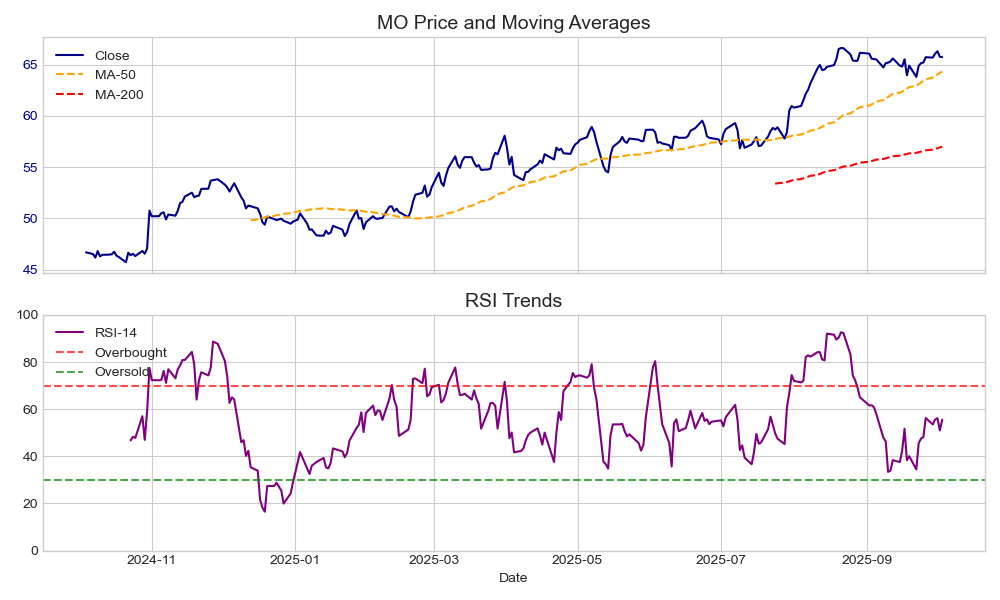

  Displaying: MO_CPIAUCSL_corr.png


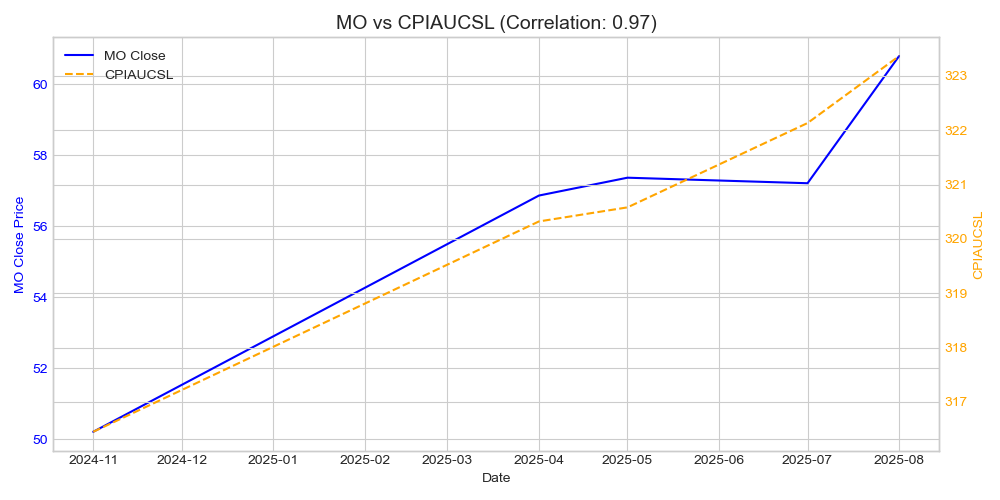


 SynthesisAgent (LLM Simulation) Generating Response...

             ✨ Final User-Facing Response ✨
###  Comprehensive Summary for MO
**Agent Confidence:** 0.57

**Key Analytical Insights:**
1. **Price Action:** The price is in a **Uptrend** trend with RSI at 55.57 (suggesting neutral).
2. **Macro Context:** Macro correlation (CPI) is **0.97**, indicating a strong positive link between the stock and inflation trends.
3. **Market Tone:** News sentiment is **neutral** (0.00 weighted score). This suggests market indecision, driven by 0 analyzed articles.

**Agent Data Conclusion:** *RSI is 55.57, Trend: Uptrend. CPI Correlation: 0.97. Weighted News Sentiment: 0.00.*


--- 2. Risk Assessment Analysis ---


Enter Ticker for Risk Assessment (e.g., TSLA):  UPS


**TICKER RECEIVED:** UPS. Running analysis...

--- User Query: "Analyze the investment risk for UPS based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags." ---
--- Agent routes as 'RISK_ASSESSMENT' intention ---
--- Formulated System Prompt: "Analyze UPS's potential risks, volatility, and sentiment." ---

🧠 Agent Starting Run for UPS (risk_assessment)
    [Tool Use] Fetching yfinance data for UPS...
    [Agent Learns] Prior Notes (N/A): No prior analysis
        [Chart] Generated Macro Correlation chart: UPS_CPIAUCSL_corr.png
        [Chart] Generated Price & RSI chart: UPS_price_rsi.png

               📊 Final Investment Report for UPS
💡 Key Findings:
  - Current RSI (14): 61.15, Regime: Uptrend
  - Macro Correlation (CPI): -0.89
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Overall Confidence: 0.57
  - Data Summary: RSI is 61.15, Trend: Uptrend. CPI

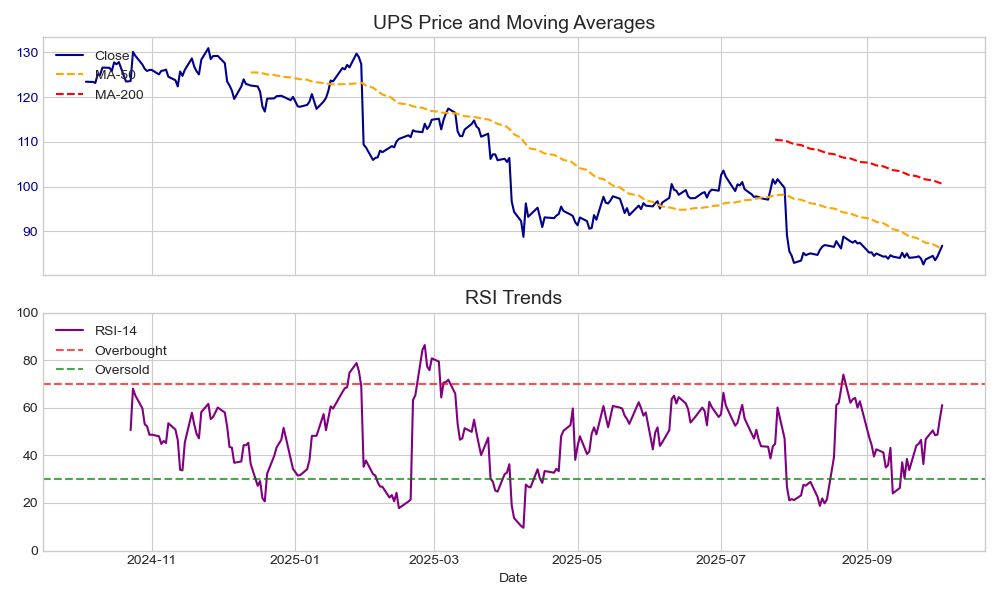

  Displaying: UPS_CPIAUCSL_corr.png


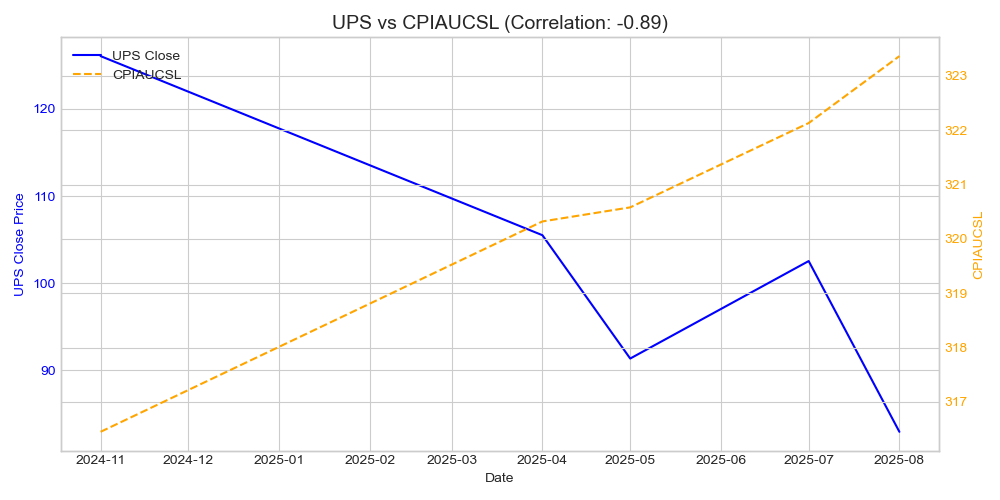


 SynthesisAgent (LLM Simulation) Generating Response...

             ✨ Final User-Facing Response ✨
###  UPS Investment Risk Assessment
**Overall Risk Profile:** Low Risk (Confidence: 0.57)

**Detailed Breakdown:**
- The price is in a **Uptrend** trend with RSI at 61.15 (suggesting neutral).
- Macro correlation (CPI) is **-0.89**, indicating a moderate link between the stock and inflation trends.
- News sentiment is **neutral** (0.00 weighted score). This suggests market indecision, driven by 0 analyzed articles.

The agent's data summary suggests: *RSI is 61.15, Trend: Uptrend. CPI Correlation: -0.89. Weighted News Sentiment: 0.00.*


--- 3. Comparison Analysis ---


Enter FIRST Ticker for Comparison (e.g., AAPL):  MO
Enter SECOND Ticker for Comparison (e.g., MSFT):  UPS


**TICKERS RECEIVED:** MO and UPS. Running comparison...

--- User Query: "Compare MO against UPS focusing on their investment performance, recent risks, and how news sentiment differs between them." ---
--- Agent routes as 'COMPARISON' intention ---
--- Formulated System Prompt: "Compare MO and UPS in performance and risk." ---
    [Workflow: Routing] Initiating parallel analysis for comparison...

🧠 Agent Starting Run for MO (comparison)
    [Tool Use] Fetching yfinance data for MO...
    [Agent Learns] Prior Notes (2025-10-05T23:14:12.710878): RSI is 55.57, Trend: Uptrend. CPI Correlation: 0.97. Weighted News Sentiment: 0.00.
        [Chart] Generated Macro Correlation chart: MO_CPIAUCSL_corr.png
        [Chart] Generated Price & RSI chart: MO_price_rsi.png

               📊 Final Investment Report for MO
💡 Key Findings:
  - Current RSI (14): 55.57, Regime: Uptrend
  - Macro Correlation (CPI): 0.97
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Eva

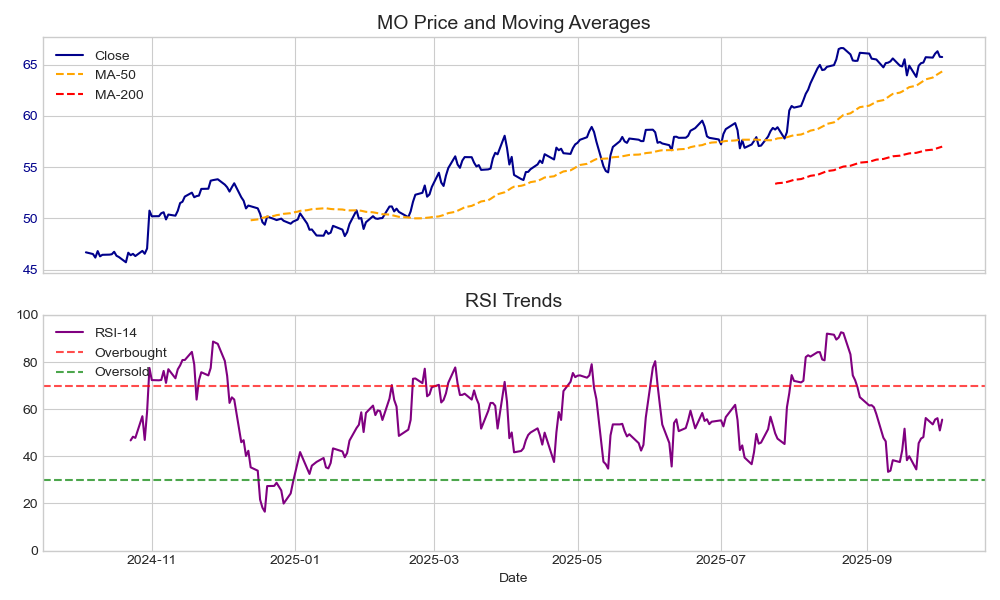

  Displaying: MO_CPIAUCSL_corr.png


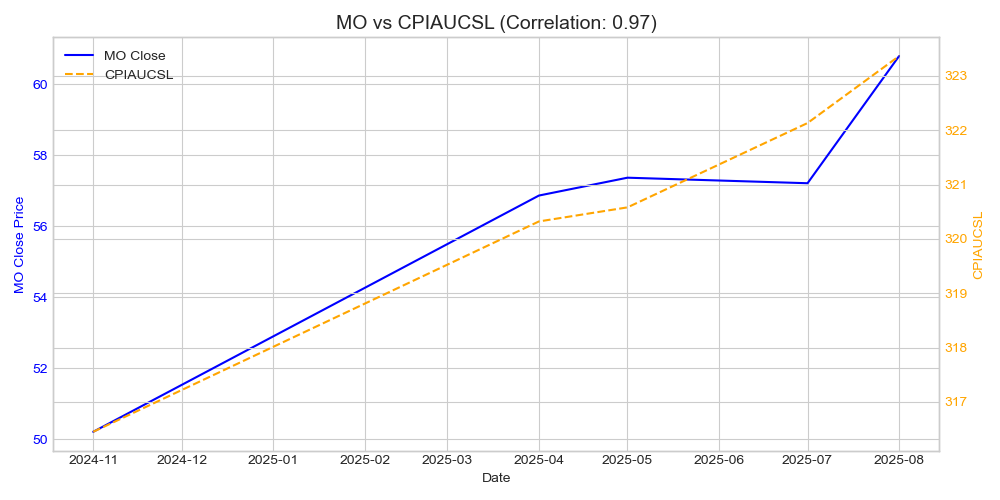


🧠 Agent Starting Run for UPS (comparison)
    [Tool Use] Fetching yfinance data for UPS...
    [Agent Learns] Prior Notes (2025-10-05T23:14:20.580876): RSI is 61.15, Trend: Uptrend. CPI Correlation: -0.89. Weighted News Sentiment: 0.00.
        [Chart] Generated Macro Correlation chart: UPS_CPIAUCSL_corr.png
        [Chart] Generated Price & RSI chart: UPS_price_rsi.png

               📊 Final Investment Report for UPS
💡 Key Findings:
  - Current RSI (14): 61.15, Regime: Uptrend
  - Macro Correlation (CPI): -0.89
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Overall Confidence: 0.57
  - Data Summary: RSI is 61.15, Trend: Uptrend. CPI Correlation: -0.89. Weighted News Sentiment: 0.00.

📈 Visual Evidence:
  Displaying: UPS_price_rsi.png


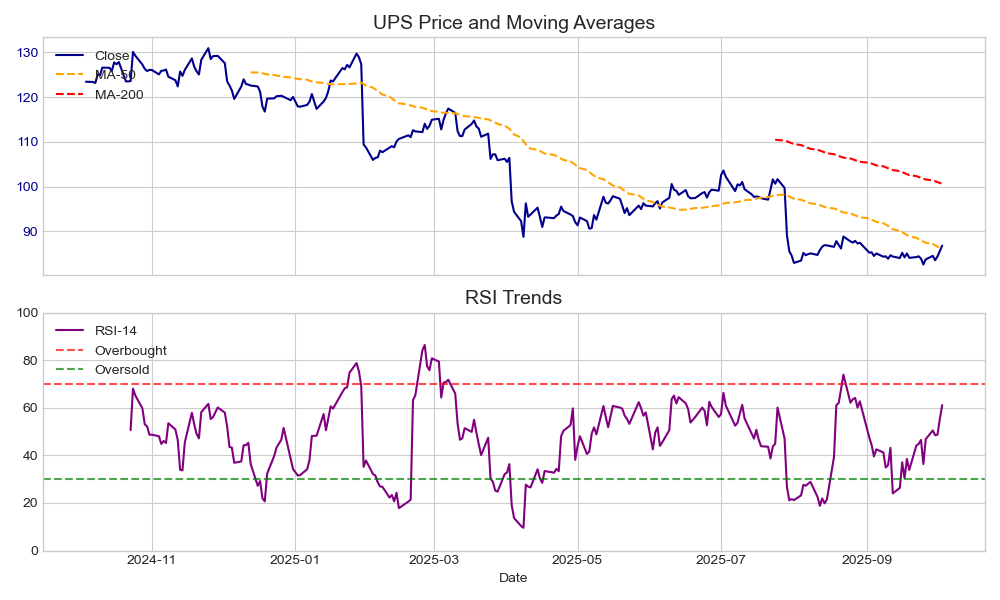

  Displaying: UPS_CPIAUCSL_corr.png


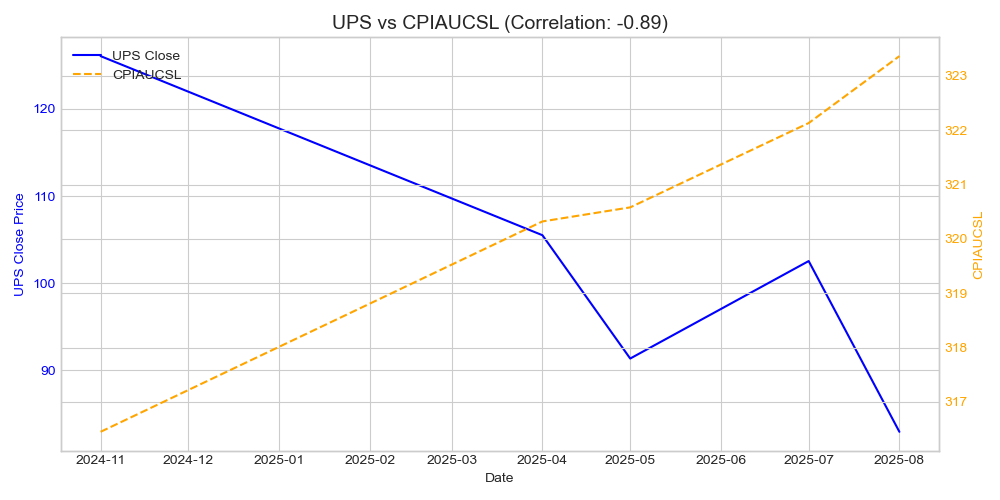


 SynthesisAgent (LLM Simulation) Generating Response...

             ✨ Final User-Facing Response ✨
###  Comparative Analysis: MO vs UPS
**Query Intent:** Comparison (Address: *Compare MO against UPS focusing on their investment performance, recent risks, and how news sentiment differs between them.*)

| Metric | MO | UPS |
| :--- | :--- | :--- |
| **Agent Confidence** | 0.57 | 0.57 |
| **RSI (14)** | 55.57 | 61.15 |
| **Price Regime** | Uptrend | Uptrend |
| **Macro Corr (CPI)** | 0.97 | -0.89 |
| **Weighted Sentiment** | 0.00 | 0.00 |

**Synthesis Conclusion:**
**MO** shows stronger overall signals supported by the agent's higher confidence score (0.57).

**MO Strengths:** None highlighted
**UPS Strengths:** Higher RSI (61.15), Better Sentiment (0.00), Higher Agent Confidence (0.57)


 INTERACTIVE MODE ENDED 


In [7]:
# INTERACTIVE EXECUTION BLOCK


# 1. Initialize the InvestmentResearchAgent
agent = InvestmentResearchAgent()
# 2. Attach a PromptManager
agent.prompt_manager = PromptManager(agent)

print("\n" + "="*70)
print(" INVESTMENT AGENT INTERACTIVE MODE ")
print("Please enter the requested ticker symbol in the box that appears below each instruction.")
print("="*70)

# --- Interactive Example 1: Summary ---
print("\n--- 1. Summary Analysis ---")
user_ticker_summary = input("Enter Ticker for Summary (e.g., AAPL): ").upper()
if user_ticker_summary:
    print(f"**TICKER RECEIVED:** {user_ticker_summary}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        f"Provide a comprehensive summary of {user_ticker_summary}'s recent performance including its RSI, key macro trends, and overall news sentiment.",
        ticker=user_ticker_summary
    )
    time.sleep(1) # Pause for clarity

# --- Interactive Example 2: Risk Assessment ---
print("\n--- 2. Risk Assessment Analysis ---")
user_ticker_risk = input("Enter Ticker for Risk Assessment (e.g., TSLA): ").upper()
if user_ticker_risk:
    print(f"**TICKER RECEIVED:** {user_ticker_risk}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        f"Analyze the investment risk for {user_ticker_risk} based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.",
        ticker=user_ticker_risk
    )
    time.sleep(1) # Pause for clarity

# --- Interactive Example 3: Comparison ---
print("\n--- 3. Comparison Analysis ---")
user_ticker1_comp = input("Enter FIRST Ticker for Comparison (e.g., AAPL): ").upper()
user_ticker2_comp = input("Enter SECOND Ticker for Comparison (e.g., MSFT): ").upper()

if user_ticker1_comp and user_ticker2_comp:
    print(f"**TICKERS RECEIVED:** {user_ticker1_comp} and {user_ticker2_comp}. Running comparison...")
    agent.prompt_manager.execute_prompt(
        f"Compare {user_ticker1_comp} against {user_ticker2_comp} focusing on their investment performance, recent risks, and how news sentiment differs between them.",
        ticker1=user_ticker1_comp,
        ticker2=user_ticker2_comp
    )
    
print("\n" + "="*70)
print(" INTERACTIVE MODE ENDED ")
print("="*70)